# Лабораторная работа 1 "Решение краевых задач. Методы коллокаций, наименьших квадратов и Галеркина"

## Теория

Рассматриваем уравнение вида:

$$
u(x)\cdot y'' + p(x) \cdot y' + q(x) \cdot y = f(x)
$$

$$
u(x), p(x), q(x), f(x) - непрерывные \ на\  отрезке\  [a, b]\ функции (в программе u = c[2], p = c[1], q = c[0], f = c0)
$$

#### Условия для базисной системы

1. $\phi_{0}$ удовлетворяет граничному условию
2. функции $\phi_{1}(x), ..., \phi_{n}(x)$ - линейно независимы на [a, b] и удовлетворяют однородным граничным условиям

Тогда по базисным функция строим приближенное решение в виде линейной комбинации базисный функций:

$$
y_{n} = \phi_{0}(x) + a_{1}\cdot\phi_{1}(x) + ... + a_{n}\cdot\phi_{n}(x)
$$

Задача сводится к выбору $a_{1}, ..., a_{n}$ таких, чтобы $y_{n}(x)$ удовлетворяла граничному условию и приближалась к граничному решению.

Невязка - выражение, вида:

$$
\psi(x, a_{1}, ..., a_{n}) = u(x) \cdot y_{n}(x)'' + p(x) \cdot y_{n}(x)' + q(x) \cdot y_{n}(x) - f(x)
$$

In [86]:
import math
import numpy as np
import matplotlib.pyplot as plt

k = 15
#c = [lambda x: 1 + (x ** 2),
#     lambda x: 0,
#     lambda x: 1]
c = [lambda x: (1+math.cos(k)*(x ** 2)),
     lambda x: 0,
     lambda x: math.sin(k)]
c0 = lambda x: -1
a0, b0 = -1, 1
h = 0.0001
df_dx =[lambda f, x: f(x),
        lambda f, x: (f(x+h)-f(x-h)) / (2*h),
        lambda f, x: (f(x-h)-2*f(x)+f(x+h)) / (h**2)]

# Simpson's integration
def integration(f, a, b, n = 100):
    h = (b - a) / n
    return h / 3 * sum([f(a + h * i) + 4 * f(a + h * (i + 1)) + f(a + h * (i + 2)) for i  in range(0, n - 1, 2)])


n = 100
dh = (b0 - a0) / (n+2)
#f = [lambda x: 0, 
#     lambda x: 1-x**2,
#     lambda x: x**2-x**4]
def gen_f(i):
    return lambda x: x**(i-1) * (1-x**2)


# f = [lambda x: 0, 
#      lambda x: 1-x**2,
#      lambda x: x**2-x**4]
f = [lambda x: 0]
for i in range(1, n):
    f.append(gen_f(i))
    
x = np.arange(a0, b0+0.01, 0.01)

### Метод коллокаций

На отрезке $[a, b]$ выбирается $m$ точек $x_{1}, ..., x_{n}$ $(m \geq n)$

Эти точки последовательно подставляются в невязку, считаю, что она должна быть равна `0`

Обычно берётся `m = n` и решается система из `n` уравнений и `n` неизвестных

Коэффициенты в матрице - частные производные:

$$\frac{\partial \psi(x_i)}{\partial a_{j}} = \sum_{k=0}^{2}c_{k}(x)\cdot\phi_j^{(k)}(x_i)$$

Значения векторов свободных членов:

$$b_i = f(x) - \sum_{k=0}^{2}c_{k}(x)\cdot\phi_0^{(k)}(x_i)$$

In [87]:
def collation(collation_point):
    matrix = []
    b = []
    for x in collation_point:
        matrix.append([sum(c[j](x)*df_dx[j](f[i], x) for j in range(3)) for i in range(1, n)])
        b.append(c0(x)-sum(c[j](x)*df_dx[j](f[0], x) for j in range(3)))
    sol = np.linalg.solve(np.array(matrix), np.array(b))
    #print(sol)
    return lambda x: f[0](x) + sum(sol[i]*f[i+1](x) for i in range(n-1))

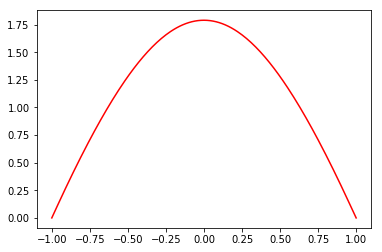

In [88]:
plt.plot(x, collation(np.linspace(a0, b0, n -1))(x), 'r')
plt.show()

### Интегральный МНК

Для нахождения коффициентов при базисных функциях минимизируется интеграл:

$$
I = \int_a^b \phi^2(x, a_1, ..., a_n)dx
$$

Для нахождения минимума интеграла решаем систему:

$$
\frac{dI}{d a_1} = 2 \int_a^b \psi(x, a_1, ..., a_n) \frac{d \psi(x, a_1, ..., a_n)}{da_1}dx = 0
$$
$$
...............................................
$$
$$
\frac{dI}{d a_n} = 2 \int_a^b \psi(x, a_1, ..., a_n) \frac{d \psi(x, a_1, ..., a_n)}{d a_n}dx = 0
$$

Коэффициенты в матрице:

$$\int_a^b\frac{\partial \psi(x)}{\partial a_{i}} \cdot\frac{\partial \psi(x)}{\partial a_{j}} dx $$

Значения вектора свободных членов:

$$b_i = \int_a^b\left(f(x) - \frac{\partial \psi(x)}{\partial a_{0}}\right)\cdot\frac{\partial \psi(x)}{\partial a_{i}} dx $$

In [89]:
def part(q):
    return lambda x: sum(c[i](x)*df_dx[i](f[q], x) for i in range(3))

In [90]:
def mnk_int():
    matrix = [[integration(lambda x: part(i)(x)*part(j)(x), a0, b0) for j in range(1, n)] for i in range(1, n)]
    b = [integration(lambda x: (c0(x)-part(0)(x))*part(i)(x), a0, b0) for i in range(1, n)]
#     print(matrix)
#     print(b)
    sol = np.linalg.solve(np.array(matrix), np.array(b))
    #print(sol)
    return lambda x: f[0](x) + sum(sol[i]*f[i+1](x) for i in range(n-1))

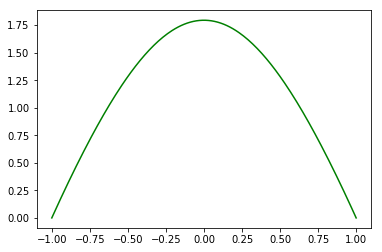

In [91]:
plt.plot(x, mnk_int()(x), 'g')
plt.show()

### Дискретный МНК

Выбирается $N > n$ точек и решается задача минимизации:

$$
S = \sum_{i=1}^{N}\psi^2(x_i, a_1, ..., a_n)
$$

Для её решение решается система:

$$
\frac{dS}{d a_1} = 0
$$
$$
.......
$$
$$
\frac{dS}{d a_n} = 0
$$

Коэффициенты в матрице:

$$\sum_{k=0}^{N}\frac{\partial \psi(x_k)}{\partial a_{i}} \cdot\frac{\partial \psi(x_k)}{\partial a_{j}} $$

Значения вектора свободных членов:

$$b_i = \sum_{k=0}^{N}\left(f(x_k) - \frac{\partial \psi(x_k)}{\partial a_{0}}\right)\cdot\frac{\partial \psi(x_k)}{\partial a_{i}} $$

In [92]:
def mnk_discr(points):
    matrix = []
    b = []
    for i in range(1, n):
        row = []
        for j in range(1, n):
            der = lambda x: part(i)(x)*part(j)(x)
            row.append(sum(der(x) for x in points))
        matrix.append(row)
        der = lambda x: (c0(x)-part(0)(x))*part(i)(x)
        b.append(sum(der(x) for x in points))
    #print(matrix)
    #print(b)
    sol = np.linalg.solve(np.array(matrix), np.array(b))
    #print(sol)
    return lambda x: f[0](x) + sum(sol[i]*f[i+1](x) for i in range(n-1))

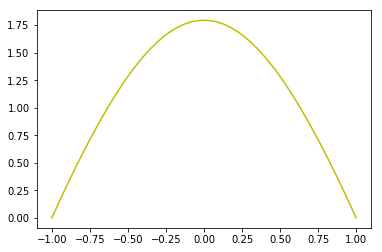

In [93]:
plt.plot(x, mnk_discr(np.linspace(a0, b0, n + 2))(x), 'y')
plt.show()

### Метод Галёркина

Рассматриваем невязку $\psi$ и для определения коэффициентов $a_1, ..., a_n$ решаем систему:


$$
\int_a^b\psi(x, a_1, ..., a_n)\cdot \phi_1(x)dx = 0
$$
$$
................................
$$
$$
\int_a^b\psi(x, a_1, ..., a_n)\cdot \phi_n(x)dx = 0
$$

Коэффициенты в матрице:

$$\int_a^b\frac{\partial \psi(x)}{\partial a_{j}} \cdot \phi_i(x) dx $$

Значения вектора свободных членов:

$$b_i = \int_a^b\left(f(x) - \frac{\partial \psi(x)}{\partial a_{0}}\right)\cdot \phi_i(x) dx $$

In [97]:
def galerkin():
    matrix = [[integration(lambda x: part(j)(x)*f[i](x), a0, b0) for j in range(1, n)] for i in range(1, n)]
#     matrix = [[f[i](b0)*df_dx[1](f[j], b0) - f[i](a0)*df_dx[1](f[j], a0) - 
#                integration(lambda x: df_dx[1](f[i], x)*df_dx[1](f[j], x), a0, b0)
#                + integration(lambda x: df_dx[1](f[i], x)*df_dx[1](f[j], x), a0, b0)
#                for j in range(1, n)] for i in range(1, n)]
    #print(matrix)
    b = [integration(lambda x: (c0(x)-part(0)(x))*f[i](x), a0, b0) for i in range(1, n)]
    #print(b)
    sol = np.linalg.solve(np.array(matrix), np.array(b))
    #print(sol)
    return lambda x: f[0](x) + sum(sol[i]*f[i+1](x) for i in range(n-1))
# print(f'x\ty(x)\n0.25\t{y(0.25)}\n0.5\t{y(0.5)}\n0.75\t{0.75}')

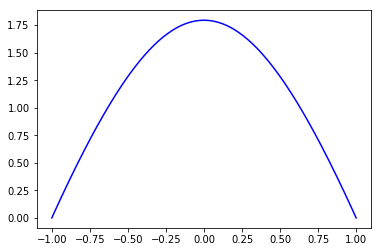

In [98]:
plt.plot(x, galerkin()(x), 'b')
plt.show()

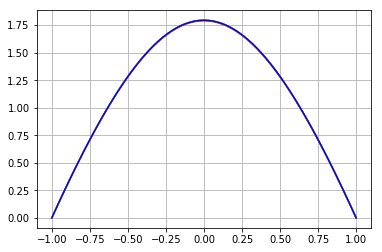

In [99]:
plt.plot(x, collation(np.linspace(a0, b0, n-1))(x), 'r')
plt.plot(x, mnk_int()(x), 'g')
plt.plot(x, mnk_discr(np.linspace(a0, b0, n + 2))(x), 'y')
plt.plot(x, galerkin()(x), 'b')
plt.grid()
plt.show()